In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.activations import relu
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras import layers as Layers
import numpy as np
import math
import sys
import os
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
from plyfile import *
from mpl_toolkits.mplot3d import Axes3D
import open3d as o3d 
import numpy as np
import scipy.stats
import random
import pandas as pd
from sklearn.metrics import confusion_matrix

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [6]:
#点云文件导入
##############导入点云数据#################
pcd_AC13_1 = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/AC13-1.ply")
pcd_AC13_2 = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/AC13-2.ply")
pcd_AC16_3 = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/AC16-3.ply")
pcd_AC16_4 = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/AC16-4.ply")
pcd_UT5_1  = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/UT5-1.ply")
pcd_UT5_2  = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/UT5-2.ply")
pcd_UT5_3  = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/UT5-3.ply")
pcd_UT5_4  = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/UT5-4.ply")
pcd_SMA13_1= o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/SMA13-1.ply")
pcd_SMA13_2= o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/SMA13-2.ply")
pcd_OGFC10_1= o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/OGFC10-1.ply")
#############点云标准化####################
def standard_pointcloud(point_cloud):
    Point_standard=[]
    Point=np.asarray(point_cloud.points)    
    x=np.array(Point[:,0])[...,np.newaxis]
    y=np.array(Point[:,1])[...,np.newaxis]
    z=np.array(Point[:,2])[...,np.newaxis]
    Point_standard=np.concatenate((x-np.min(x),y-np.min(y),z-np.min(z)),axis=-1)
    return Point_standard
    
AC13_1=standard_pointcloud(pcd_AC13_1)
AC13_2=standard_pointcloud(pcd_AC13_2)
AC16_3=standard_pointcloud(pcd_AC16_3)
AC16_4=standard_pointcloud(pcd_AC16_4)
UT5_1=standard_pointcloud(pcd_UT5_1)
UT5_2=standard_pointcloud(pcd_UT5_2)
UT5_3=standard_pointcloud(pcd_UT5_3)
UT5_4=standard_pointcloud(pcd_UT5_4)
SMA13_1= standard_pointcloud(pcd_SMA13_1)
SMA13_2= standard_pointcloud(pcd_SMA13_2)
OGFC10_1 =  standard_pointcloud(pcd_OGFC10_1)

point_cloud_array_group = []
point_cloud_array_group.append(AC13_1)
point_cloud_array_group.append(AC13_2)
point_cloud_array_group.append(AC16_3)
point_cloud_array_group.append(AC16_4)
point_cloud_array_group.append(UT5_1)
point_cloud_array_group.append(UT5_2)
point_cloud_array_group.append(UT5_3)
point_cloud_array_group.append(UT5_4)
point_cloud_array_group.append(SMA13_1)
point_cloud_array_group.append(SMA13_2)
point_cloud_array_group.append(OGFC10_1)
#############点云标准化####################
def standard_pointcloud(point_cloud):
    Point_standard=[]  
    x=np.array(point_cloud[:,0])[...,np.newaxis]
    y=np.array(point_cloud[:,1])[...,np.newaxis]
    z=np.array(point_cloud[:,2])[...,np.newaxis]
    Point_standard=np.concatenate((x-np.min(x),y-np.min(y),z-np.min(z)),axis=-1)
    return Point_standard
#############点云转体素####################
def voxel_transform(point_cloud, leaf_size, x_max, y_max, z_max, random=False):
    # 计算边界点
    """
    x_min, y_min, z_min = np.amin(point_cloud, axis=0) #计算x y z 三个维度的最值
    x_max, y_max, z_max = np.amax(point_cloud, axis=0)
    """
    x_min = 0
    y_min = 0
    z_min = 0
    # 计算 voxel grid维度
    Dx = (x_max - x_min)//leaf_size + 1
    Dy = (y_max - y_min)//leaf_size + 1
    Dz = (z_max - z_min)//leaf_size + 1
    #print("Dx x Dy x Dz is {} x {} x {}".format(Dx, Dy, Dz))
    
    #建立包络空间
    filtered_points = np.zeros(shape=(int(Dx),int(Dy),int(Dz),1))
 
    # 计算每个点的voxel索引
    for i in range(len(point_cloud)):
        hx = int((point_cloud[i][0] - x_min)//leaf_size)
        hy = int((point_cloud[i][1] - y_min)//leaf_size)
        hz = int((point_cloud[i][2] - z_min)//leaf_size)
        filtered_points[hx][hy][hz][0]=1
        
    return  filtered_points
######################按照计算的H_final进行窗口滑动切分#########################
H_final=51
AC13=[0,6,4,3.5,5.5,7.5,10.5,16,23.5,18.5,5,0]#级配
AC16=[0,5.4,2.4,2.4,3.7,4.1,7.8,5.5,26.3,20.1,16.6,5.7]#级配 
SMA13=[0,10.7,2.1,1.4,1.1,1.2,2.9,9.4,30.3,31.5,8.2,1.2]#级配
UT5=[0,6.7,2,2.5,5,20,13.4,48.8,1.5,0.1,0,0]#级配
OGFC10=[0,4,1.5,2,2,2.5,4,44,35,5,0,0]#级配
def split_slide(point_cloud_array_origion,H_new=H_final, intervial =[5,5]):
    L=int(np.max(point_cloud_array_origion[:,0]))
    W=int(np.max(point_cloud_array_origion[:,1]))
    Vox_small = []
    L_intervial = intervial[0]
    W_intervial = intervial[1]
    for i in range (0,L-H_new,L_intervial):
        for j in range (0,W-H_new,W_intervial):
            temp_point_cloud = point_cloud_array_origion[np.where((point_cloud_array_origion[:,1]>i)&
                                                                  (point_cloud_array_origion[:,1]<(H_new+i))&
                                                                  (point_cloud_array_origion[:,0]>j)&
                                                                  (point_cloud_array_origion[:,0]<(H_new+j)))]
            temp_point_cloud = standard_pointcloud(temp_point_cloud)
            ####点云转体素
            temp_Vox = voxel_transform(temp_point_cloud, leaf_size=0.5,x_max=51,y_max=51,z_max=10, random=False)

            Vox_small.append(temp_Vox)
    
    return Vox_small
####################原始图像拆分子点云集########################################
PointCloud_new =np.zeros((1,103,103,21,1))
#制作Ground truth
Y_Data=np.zeros((1,12))
###################辅助信息###########################
F_AC13_1 =[1.24,0.63,0.51,-0.48,3.61,-2.33,-0.41,-0.07,0.16,0.42,1.68,0.87]
F_AC13_2 =[1.26,0.59,0.45,-0.56,3.58,-1.96,-0.33,-0.03,0.18,0.39,1.72,0.91]
F_AC16_3 =[0.92,0.77,0.76,-0.93,4.06,-3.38,-0.49, 0.02,0.36,0.68,1.28,0.93]
F_AC16_4 =[1.27,0.87,0.96,-0.75,3.74,-4.47,-0.64,-0.04,0.45,0.90,1.78,1.04]
F_UT5_1  =[0.49,0.54,0.39,-1.44,7.12,-3.55,-0.17, 0.06,0.21,0.34,0.72,0.63]
F_UT5_2  =[0.53,0.56,0.40,-1.13,5.12,-2.49,-0.24, 0.03,0.21,0.35,0.75,0.71]
F_UT5_3  =[0.49,0.54,0.39,-1.44,7.12,-3.55,-0.17, 0.06,0.21,0.34,0.72,0.63]
F_UT5_4  =[0.53,0.56,0.40,-1.13,5.12,-2.49,-0.24, 0.03,0.21,0.35,0.75,0.71]
F_SMA13_1=[1.33,1.04,1.35,-0.93,4.07,-6.09,-0.63, 0.30,0.82,1.28,2.05,0.95]
F_SMA13_2=[1.42,1.00,1.29,-1.33,5.75,-7.60,-0.74, 0.17,0.71,1.12,2.05,1.05]
F_OGFC10 =[1.77,0.77,0.75,-0.97,4.77,-4.47,-0.44, 0.08,0.39,0.66,2.41,1.52]
Aided_information = np.zeros((1,12))
for i in range(11):
    temp=split_slide(point_cloud_array_group[i])
    #print(len(temp))
    PointCloud_new=np.concatenate((PointCloud_new,temp),axis=0)
    if (i==0): 
        temp2 = np.full((len(temp),12),AC13)
        temp3 = np.full((len(temp),12),F_AC13_1)
    elif (i==1):
        temp2 = np.full((len(temp),12),AC13)
        temp3 = np.full((len(temp),12),F_AC13_2)
    elif (i==2):
        temp2 = np.full((len(temp),12),AC16)
        temp3 = np.full((len(temp),12),F_AC16_3)
    elif (i==3):
        temp2 = np.full((len(temp),12),AC16)
        temp3 = np.full((len(temp),12),F_AC16_4)
    elif (i==4):
        temp2 = np.full((len(temp),12),UT5)
        temp3 = np.full((len(temp),12),F_UT5_1)
    elif (i==5):
        temp2 = np.full((len(temp),12),UT5)
        temp3 = np.full((len(temp),12),F_UT5_2)
    elif (i==6):
        temp2 = np.full((len(temp),12),UT5)
        temp3 = np.full((len(temp),12),F_UT5_3)
    elif (i==7):
        temp2 = np.full((len(temp),12),UT5)
        temp3 = np.full((len(temp),12),F_UT5_4)
    elif (i==8):
        temp2 = np.full((len(temp),12),SMA13)
        temp3 = np.full((len(temp),12),F_SMA13_1)
    elif (i==9):
        temp2 = np.full((len(temp),12),SMA13)
        temp3 = np.full((len(temp),12),F_SMA13_2)     
    elif (i==10):
        temp2 = np.full((len(temp),12),OGFC10)
        temp3 = np.full((len(temp),12),F_OGFC10)  
    #print(temp2.shape)
    Y_Data = np.concatenate((Y_Data,temp2),axis=0)
    Aided_information = np.concatenate((Aided_information,temp3),axis=0)
    #print(np.array(Y_Data).shape)
Y_Data = np.delete(Y_Data, 1, 0)#把第一行0删掉
Aided_information = np.delete(Aided_information, 1, 0)#把第一行0删掉
print(Y_Data.shape)
print(Aided_information.shape)
PointCloud_new = np.delete(PointCloud_new, 1, 0)#把第一行0删掉
PointCloud_new =np.array(PointCloud_new)
print(Y_Data.shape)
print(PointCloud_new.shape)

(1579, 12)
(1579, 12)
(1579, 12)
(1579, 103, 103, 21, 1)


In [8]:
#### 数据集1579分，切分为1379训练 200测试#######################
arr = np.array(range(0, 1579, 1))
r = np.random.permutation(arr)
Train_X1_Data = []
Train_X2_Data = []
Train_Y_Data = []
for i in range(1379):
    Train_X1_Data.append(PointCloud_new[r[i]])
    Train_X2_Data.append(Aided_information[r[i]])
    Train_Y_Data.append(Y_Data[r[i]])

Test_X1_Data = []
Test_X2_Data = []
Test_Y_Data = []
for i in range(1379,1579):
    Test_X1_Data.append(PointCloud_new[r[i]])
    Test_X2_Data.append(Aided_information[r[i]])
    Test_Y_Data.append(Y_Data[r[i]])
    
Train_X1_Data = np.array(Train_X1_Data)
Train_X2_Data = np.array(Train_X2_Data)
Train_Y_Data = np.array(Train_Y_Data)
Test_X1_Data = np.array(Test_X1_Data)
Test_X2_Data = np.array(Test_X2_Data)
Test_Y_Data = np.array(Test_Y_Data)

print(Train_X1_Data.shape)
print(Train_X2_Data.shape)
print(Train_Y_Data.shape)
print(Test_X1_Data.shape)
print(Test_X2_Data.shape)
print(Test_Y_Data.shape)

(1379, 103, 103, 21, 1)
(1379, 12)
(1379, 12)
(200, 103, 103, 21, 1)
(200, 12)
(200, 12)


In [9]:
class ResBlock(Model):
    def __init__(self, channels, stride=1):
        super(ResBlock, self).__init__(name='ResBlock')
        self.flag = (stride != 1)
        self.conv1 = Conv3D(channels, 3, stride, padding='same')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv3D(channels, 3, padding='same')
        self.bn2 = BatchNormalization()
        self.relu = ReLU()
        if self.flag:
            self.bn3 = BatchNormalization()
            self.conv3 = Conv3D(channels, 1, stride)

    def call(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        x1 = self.conv2(x1)
        x1 = self.bn2(x1)
        if self.flag:
            x = self.conv3(x)
            x = self.bn3(x)
        x1 = Layers.add([x, x1])
        x1 = self.relu(x1)
        return x1


class ResNet34(Model):
    def __init__(self, num_classes):
        super(ResNet34, self).__init__(name='ResNet34')
        self.conv1 = Conv3D(64, 7, 2, padding='same')
        self.bn = BatchNormalization()
        self.relu = ReLU()
        self.mp1 = MaxPooling3D(3, 2)

        self.conv2_1 = ResBlock(64)
        self.conv2_2 = ResBlock(64)
        self.conv2_3 = ResBlock(64)

        self.conv3_1 = ResBlock(128, 2)
        self.conv3_2 = ResBlock(128)
        self.conv3_3 = ResBlock(128)
        self.conv3_4 = ResBlock(128)

        self.conv4_1 = ResBlock(256, 2)
        self.conv4_2 = ResBlock(256)
        self.conv4_3 = ResBlock(256)
        self.conv4_4 = ResBlock(256)
        self.conv4_5 = ResBlock(256)
        self.conv4_6 = ResBlock(256)

        self.conv5_1 = ResBlock(512, 2)
        self.conv5_2 = ResBlock(512)
        self.conv5_3 = ResBlock(512)

        self.pool = GlobalAveragePooling3D()
        self.fc11 = Dense(512, activation='relu')
        self.fc1 = Dense(512, activation='relu')
        self.dp1 = Dropout(0.5)
        self.fc2 = Dense(512, activation='relu')
        self.dp2 = Dropout(0.5)
        self.fc3 = Dense(num_classes, activation='relu')
        
        self.Fdense1 = Dense(512, activation='relu')
        self.bnF1 = BatchNormalization()
        self.Fdense2 = Dense(512, activation='relu')

    def call(self,input):
        x1,x2 =input
        x = self.conv1(x1)
        x = self.bn(x)
        x = self.relu(x)
        x = self.mp1(x)

        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.conv2_3(x)

        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        x = self.conv3_4(x)

        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.conv4_3(x)
        x = self.conv4_4(x)
        x = self.conv4_5(x)
        x = self.conv4_6(x)

        x = self.conv5_1(x)
        x = self.conv5_2(x)
        x = self.conv5_3(x)

        x = self.pool(x)
        x = self.fc11(x)
        
        F_x= self.Fdense1(x2)
        F_x= self.bnF1(F_x)
        F_x= self.Fdense2(F_x)
        x= concatenate([x,F_x],axis=-1)
        
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.fc3(x)
        return x

In [11]:
Vox_ResNet34 = ResNet34(num_classes=12)
Vox_ResNet34.build(input_shape=[(None,103, 103, 21, 1),(None,12)])
Vox_ResNet34.summary()
Batch_size=8
lr=1e-3
Vox_ResNet34.compile(optimizer=keras.optimizers.Adam(lr), loss=tf.keras.losses.MAE)
Callback = keras.callbacks.ModelCheckpoint("Vox_ResNet34-辅助信息.tf", 
                                           monitor='val_loss', 
                                           save_best_only=True, 
                                           save_weights_only=True)
Model_history=Vox_ResNet34.fit(x=[Train_X1_Data,Train_X2_Data],y=Train_Y_Data,batch_size=Batch_size,epochs =200, validation_split=0.2,callbacks=Callback)

Model: "ResNet34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_72 (Conv3D)           multiple                  22016     
_________________________________________________________________
batch_normalization_74 (Batc multiple                  256       
_________________________________________________________________
re_lu_34 (ReLU)              multiple                  0         
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 multiple                  0         
_________________________________________________________________
ResBlock (ResBlock)          multiple                  221824    
_________________________________________________________________
ResBlock (ResBlock)          multiple                  221824    
_________________________________________________________________
ResBlock (ResBlock)          multiple                  221

138/138 [==============================] - 15s 107ms/step - loss: 1.5182 - val_loss: 0.8386 - loss:  - ETA:  - ETA: 11s - loss: 1. - ETA: 11s - loss: 1. - ETA: 11 - ETA: 10s - loss:  - ETA: 10s - loss: 1.53 - ETA: 10s - loss - ETA: 9s - loss: 1.53 - ETA: 9s - loss - ETA: 8s - loss: 1.541 - ETA: 8s - loss - ETA: 7s - los - ETA: 6s - los - ETA: 5s - loss: 1.5 - ETA: 5s - loss: 1.53 - ETA: 5s - loss: 1.5 - ETA: 5s - ETA: 3s - loss: 1.53 - ETA: 3s - lo - ETA: 2s - loss: 1 - ETA: 1s - loss: - ETA: 1s - loss: 1.522 - ETA: 1s - lo - ETA: 0s - loss: 1.518 - ETA: 0s - loss: 1.51
Epoch 10/200
138/138 [==============================] - 15s 106ms/step - loss: 1.5573 - val_loss: 1.0668s: 1. - ETA: 10s - loss: 1.59 - ETA: 10s - lo - ETA: 10s - ETA: 8s - loss: - ETA: 7s - loss: 1.60 - ETA: 7s - loss: 1.60 - ETA: 7s - loss - ETA: 6s - loss:  - ETA: 6s - loss: 1.597 - ETA: 6s  - ETA: 4s - loss: 1.586 - ETA: 4s -  - ETA: 3s - loss: 1.5 - ETA: 3s - loss: 1 - ETA - ETA: 0s - loss: 1.56 - ETA: 0s - loss:
E

138/138 [==============================] - 15s 107ms/step - loss: 1.0771 - val_loss: 0.6761A - ETA: 10s - loss: 1.09 - ETA: 10s - loss - ETA: 10s - lo - ETA: 9s - loss: 1.1 - ETA: 9s - loss: 1. - ETA: 8s - loss:  - ETA: 8s - loss: - ETA: 7s - loss: 1.09 - ETA: 7s - loss: 1 - ETA: 6s - loss: 1.095 - ETA: 6s - loss: 1.0 - ETA: 6s - loss - ETA: 3s - los - ET - ETA: 0s - loss: 1
Epoch 25/200
138/138 [==============================] - 15s 107ms/step - loss: 1.0165 - val_loss: 0.4435ETA: 13s - loss:  - ETA: 12s  - ETA: 12s - loss - ETA: 11s - loss - ETA: 11s - loss - ETA:  - ETA: 9s - loss: 1.068 - ETA: 9s - loss: - ETA: 9s - loss: 1 - ETA: 8s - loss: 1. - ETA: 8s - loss: 1 - ETA: 7s - loss: 1.046 - ETA: 7s - - ETA: 6s - loss: 1.038 - ETA: 6s - loss: 1.03  - ETA: 3s - loss: 1. - ETA: 3s - loss: - ETA: 2s - loss:  - ETA: 1s - loss:  - ETA: 1s - l - ETA: 0s - loss: 1.
Epoch 26/200
138/138 [==============================] - 15s 107ms/step - loss: 1.0049 - val_loss: 0.5734A: 12s -  - ETA - ETA: 

138/138 [==============================] - 15s 108ms/step - loss: 0.7791 - val_loss: 0.5344A: 9s - loss: 0.7 - ETA: 9s - loss: 0.757 - ETA: 9s  - ETA: 7s - ETA: 6s - loss:  - ETA: 5s - loss: 0.77 - ETA: 5s - loss - ETA: 4s - loss: 0.772 - ETA: 4s - loss: 0.772 - ETA: 4s - loss: 0.77 - ETA: 4s  - ETA: 2s - loss: 0.775 - ETA: 2s - loss: 0.77 - ETA: 2s - l - ETA: 1s - l - ETA: 0s - loss: 0
Epoch 42/200
138/138 [==============================] - 15s 108ms/step - loss: 0.8174 - val_loss: 0.5218s: 0. - ETA:  - ETA:  - ETA: 8s - loss: 0. - ETA: 7s - los - ETA: 6s - loss: 0.83 - ETA: 6s - loss: 0.8 - ETA: 6s - loss: 0.835 - ETA: 6s - loss: 0.83 - ETA: 6s - loss:  - ETA: 5s - loss:  - ETA: 4s  - ETA: 3s - loss: 0.82 - ETA: 3s - loss:  - ETA: 2s - lo - ETA: 1s - loss: 0 - ETA: 1s - loss: 0.81 - ETA: 1s - loss: 0.8 - ETA: 0s - loss:  - ETA: 0s - loss: 0.8
Epoch 43/200
138/138 [==============================] - 15s 107ms/step - loss: 0.7828 - val_loss: 0.4782ETA: 12s - loss: 0. - ETA: 12s - loss -

138/138 [==============================] - 15s 107ms/step - loss: 0.7011 - val_loss: 0.2264o - ETA: 10s - loss: 0.68 - ETA: 10s - - ETA: 9s - loss: - ETA: 8s - loss: 0.69 - ETA: 8s - loss: 0. - ETA: 8s - loss: 0. - ETA: 7s - loss: 0.695 - ETA: 7s - loss: 0. - ETA: 7s - loss: 0.69 - ETA: 7s - loss: 0.6 - ETA: 6s - loss: - ETA: 6s - loss: 0. - ETA: 5s - ETA: 4s - loss: 0.6 - ETA: 3s - loss: 0. - ETA: 3s - loss - ETA: 2s - loss: 0 - ETA: 2s - loss: 0 - ETA: 1s - loss:  - ETA: 1s - loss: 0. - ETA: 0s - loss
Epoch 58/200
138/138 [==============================] - 15s 107ms/step - loss: 0.6654 - val_loss: 0.3578- loss: - ETA: 8s - loss: 0.639 - ETA: 8s - loss: 0 - ETA: 8s - loss: 0.6 - ETA: 8s - loss: 0.6 - ETA: 7s - loss:  - ETA: 7s - loss: 0.65 - ETA: 6s -  - ETA: 3s - loss: 0.661 - ETA: 3s - loss: 0.66 - ETA: 2s - loss: 0.661 - ETA: 2s - l - ETA: 1s - los - ETA: 0s - loss: 0.66 - ETA: 0s - loss
Epoch 59/200
138/138 [==============================] - 15s 108ms/step - loss: 0.7379 - val_los

138/138 [==============================] - 15s 107ms/step - loss: 0.7086 - val_loss: 0.2653E - ETA: 12s - loss: 0. - ETA: 11 - ETA: 11 - ETA: 10s - loss: - ETA: 9s - loss: 0.7 - ETA: 9s - loss: 0.7 - ETA: 9s - l - ETA: - ETA: 6s -  - ETA: 5s - loss: 0.72 - ETA: 5s - loss: 0.72 - ETA: 4s - loss: - ETA: 4s - loss:  - ETA: 3s - l - ETA: 2s - loss: 0.71 - ETA: 2s - los - ETA: 1s
Epoch 75/200
138/138 [==============================] - 15s 107ms/step - loss: 0.6601 - val_loss: 0.2476A: 13s - loss - ETA: 12s - loss: 0.62 - ETA: 12s - loss: 0. - ETA:  - ETA: 11s - ETA: 6s - loss: - ETA: 5s - loss: 0.65 - ETA: 5s - loss: - ETA: 4s - loss: 0. - ETA: 4s - loss - ETA: 3s - los - ETA: 2s - loss:  - ETA: 2s - loss: 0. - ETA: 1s - loss: 0.66 - ETA: 1s - - ETA: 0s - loss: 0
Epoch 76/200
138/138 [==============================] - 15s 107ms/step - loss: 0.6747 - val_loss: 0.2771 loss:  - ETA: 10s  - ETA: 10s - loss: 0. - ETA: 10s - loss: 0. - ETA: 9s - loss: 0.66 - ETA: 9s - loss: 0.6 - ETA: 9s - ETA: 7

138/138 [==============================] - 16s 113ms/step - loss: 0.6042 - val_loss: 0.1980
Epoch 101/200
138/138 [==============================] - 15s 110ms/step - loss: 0.6119 - val_loss: 0.2598s: 0.62 - ETA: 9s - loss: 0 - ETA:  - ETA: 6s - loss: 0.620 - ETA: 6s - los - ETA: 5s - loss: 0.61 - ETA: 5 - ETA:  - ETA - ETA: 0s - loss: 0
Epoch 102/200
138/138 [==============================] - 15s 109ms/step - loss: 0.6575 - val_loss: 0.2721 - ETA: 6s - ETA - ETA: 3s - los - ETA: 2s - loss: 0.6 - ETA: 1s - loss: 0.659 - ETA: 1s - l - ETA: 0s - loss: 0.658 - ETA: 0s - loss: 0.658 - ETA: 0s - loss: 0
Epoch 103/200
138/138 [==============================] - 15s 108ms/step - loss: 0.6234 - val_loss: 1.1257 ETA: 8s - loss: - ETA: 8s - loss: 0.6 - ETA: - ETA: 6s - loss: 0 - ETA: 5s - loss: 0 - ETA: 5s - loss - ETA: 4s - loss: 0.622 - ETA: 4s - loss: - ETA: 3s - loss: - ETA: 2s - loss: 0.62 - ETA: 2s - loss: 0.62 - ETA: 2s - l - ETA: 1s - loss: 0. - ETA: 0s - loss: 0.62 - ETA: 0s - loss: 0. - 

138/138 [==============================] - 15s 108ms/step - loss: 0.5856 - val_loss: 1.1517 -  - ETA: 12 - ETA: 11s - loss:  - ETA: 11s - loss:  - ETA: 1 - ETA: 9s - loss: 0.58 - ETA: 9s - loss: 0.5 - ETA: 9s - ETA: 7s - loss: 0.5 - ETA: 7s - loss: 0. - ETA: 7s - loss: 0.583 - ETA: 7s - loss - ETA: - ETA: 4s - loss: 0 - ETA: 3s - loss: 0.5 - ETA: 3s - loss: 0.5 - ETA: 3 - ETA: 1s - loss:  - ETA: 1s - 
Epoch 119/200
138/138 [==============================] - 15s 108ms/step - loss: 0.5896 - val_loss: 0.27822s - loss: 0. - ETA: 12s - loss: 0. - ETA: 12s - loss: 0.63 - ETA: 12s - lo - ETA: 11s - loss: 0. - ETA: 11s - los - ETA: 9s - ETA: 8s - - ETA: 7s - loss: 0.58 - ETA: 6s - loss: 0.5 - ETA: 6s - loss: 0.5 - ETA: 6s - loss: 0.5 - ETA: 5s - loss: 0.583 - ETA: 5s - loss: 0.58 - ETA: 5s - loss: 0.5 - ETA: 5s - loss: 0.584 - ETA: 5s - loss: 0 - ETA: 4s - loss:  - ETA: 4s - loss: 0.58 - ETA: 3s - loss: 0.585 - ETA: 3s - lo - ETA: 2s - loss: 0.587 - ETA: 2s - los - ETA: 1s - loss: 0 - ETA: 1s 

138/138 [==============================] - 15s 107ms/step - loss: 0.5706 - val_loss: 0.2166- ETA: 11s - loss - ETA: - ETA: 7s - loss: 0.572 - ETA: 7s - loss: 0. - ETA: 7s - loss: 0.5 - ETA: 7s - loss: 0.5 - ETA: 6s - loss:  - ETA: 6s - loss: 0.57 - ETA: 5s - loss:  - ETA: 5s - loss: 0.57 - ETA: 5s - loss: 0.570 - ETA: 5s - loss: 0. - ETA: 4s - loss - ET - ETA: 1s - loss: 0. - ETA: 1s - loss:  - ETA: 0s - lo
Epoch 136/200
138/138 [==============================] - 15s 107ms/step - loss: 0.5584 - val_loss: 0.2057ETA: 11s - loss:  - ETA: 11s -  - ETA: 10s - lo - ETA: 10s - loss: 0. - ETA: 10s - loss: 0.56 - ETA: 10s - loss: - ETA: 9s - loss:  - ETA: 9s - loss: 0.561 - ETA: 8s - loss: 0 - ETA: 8s  - ETA: 7s - l - ETA: 5s - loss: - ETA: 5s - loss: 0.5 - ETA: 4s - loss: 0 - ETA: 4s - loss: 0.558 - ETA: 4s - loss:  - ETA: 3s - loss: 0 - ETA: 3s - loss: 0.55 - ETA:  - ETA: 1s - loss: 0 - ETA: 0s - loss: 0 - ETA: 0s - loss: 0
Epoch 137/200
138/138 [==============================] - 15s 107ms/st

138/138 [==============================] - 15s 107ms/step - loss: 0.6811 - val_loss: 0.2391 ETA: 9s - l - ETA: 8s - loss: 0. - ETA: 7s - loss: 0.7 - ETA: 7s - loss: 0. - ETA: 6s - loss: 0. - ETA: 6s - loss: 0.6 - ETA: 6s - loss - ETA: 5s - loss: 0. - ETA: 4s -  - ETA: 3s - lo - ETA: 2s - loss: 0.68 - ETA: 2s - loss: 0.683 - ETA: 2s - loss: - ETA: 1s - loss: - ETA: 1s - loss: 0.6 - ETA: 0s - loss:  - ETA: 0s - loss: 0.68 - ETA: 0s - loss: 0.681
Epoch 153/200
138/138 [==============================] - 15s 107ms/step - loss: 0.5873 - val_loss: 0.26402s - loss: 0. - ETA: 12s - loss: 0. - ETA: 12s - loss: 0.58 - ETA: 12 - ETA: 11s - loss - ETA: 10s - loss: - ETA: 8s - loss: 0. - ETA: 8s - loss: - ETA: 7s - loss: - ETA: 6s - loss: 0.583 - ETA: 6s - loss: 0. - ETA: 6s - loss: 0 - ETA: 5s - loss:  - ETA: 5s - loss: 0 - ETA: 4s - loss: - ETA: 4s - loss - ETA: 3s - loss: 0.5 - ETA: 2s - loss - ETA: 2s - loss: 0. - ETA: 1s - loss: 0.5 - ETA: 1s - loss:  - ETA: 0s - lo
Epoch 154/200
138/138 [=====

138/138 [==============================] - 15s 108ms/step - loss: 0.5837 - val_loss: 0.2163A: 12s - loss:  - ETA: 12s  - ETA: 11s - loss:  - ETA: 11s - loss - ETA: 11s - lo - ETA: 10s - loss - ETA: 10s - loss - ETA: 9s - loss: 0. - ETA: 9s - loss: 0.601  - ETA: 6s - loss: 0.59 - ETA:  - ETA: 4s - loss: 0. - ETA: 4s - loss:  - ETA: 3s - loss: 0.58 - ETA: 3s - loss: 0.58 - ETA: 3s - loss: 0.58 - ETA: 3s - loss: 0.58 - ETA: 3s - loss: 0.5 - ETA: 2s -  - ETA: 1s - los - ETA: 0s - loss: 0.584 - ETA: 0s - loss: 0 - ETA: 0s - loss: 0.58
Epoch 171/200
138/138 [==============================] - 15s 107ms/step - loss: 0.5523 - val_loss: 0.2363 12s - loss - ETA: 12s - loss: 0.52 - ETA: 12s - loss: 0. - ETA: 12s - loss - ETA: 11s - loss: 0.53 - ETA: 11s - loss:  - ETA: 11s - loss -  - ETA: 9s - loss: 0. - ETA: 9s - loss: 0.548 - E - ETA: 7s - loss: 0.5 - ETA: 6s - loss: 0. - ETA: 6s - loss: 0.551 - ETA: 6s - - ETA: 5s - los - ETA: 4s - loss: 0 - ETA: 3s - loss: 0 - ETA: 3s - loss:  - ETA: 2s - los

138/138 [==============================] - 15s 108ms/step - loss: 0.5241 - val_loss: 0.2011ETA: 9s - l - ETA: 8s - loss: 0.506 - ETA: 8s - loss - ETA: 7s - loss: 0.5 - ETA: 7s - loss: 0.5 - ETA: 7s - loss: 0.51 - ETA: 6s - loss: 0.51 - ETA: 6s - loss: 0.51 - ETA: 6s - loss: - ETA: 5s - loss: 0.5 - ETA: 5s - loss: 0.5 - ETA: 5s - loss: 0. - ETA: 4s - loss:  - ETA: 4s - loss: - ETA: 3s - loss: 0.519 - ETA: 3s - loss: 0. - ETA: 3s - loss: - ETA: 2s - loss: 0 - ETA: 1s - loss: 0 - ETA: 1s - loss: 0.5 - ETA: 1s - loss: 0.522 - ETA: 0s - los - ETA: 0s - loss: 0.52
Epoch 187/200
138/138 [==============================] - 15s 107ms/step - loss: 0.5465 - val_loss: 0.2499A: 12s - loss: 0. - ETA - ETA: 10s - loss: 0.54 - ETA: 10s - loss: 0 - ETA: 9s - loss: 0 - ETA: 9s - loss: 0.54 - ETA: 8s - loss:  - ETA: 8s - loss: 0.5 - ETA: 8s - los - ETA: 7s - loss: 0. - ETA: 6s - loss: 0 - ETA: 6s - loss: 0.544 - ETA: 6s - loss: 0 - ETA: 5s - loss: 0.5 - ETA: 5s - loss: 0 - ETA: 4s - loss:  - ETA: 4s - los

In [12]:
Save_history = Model_history.history
Save_history = pd.DataFrame(Save_history)
writer = pd.ExcelWriter('C:/Users/Administrator/Desktop/surface/实验结果存放/Vox-ResNet34_辅助信息.xlsx')  #关键2，创建名称为hhh的excel表格
Save_history.to_excel(writer,'page_1',float_format='%.5f')  #关键3，float_format 控制精度，将data_df写到hhh表格的第一页中。若多个文件，可以在page_2中写入
writer.save()  

7/7 [==============================] - 1s 54ms/step - loss: 0.1422


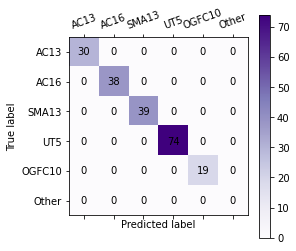

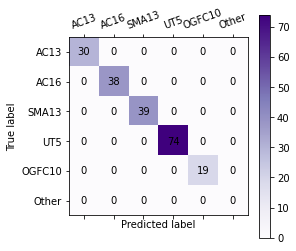

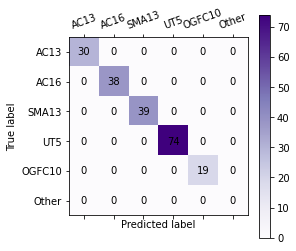

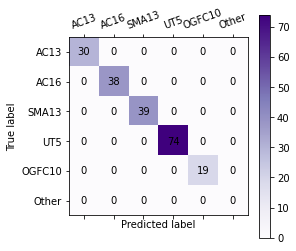

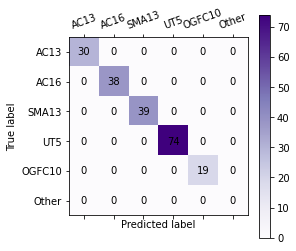

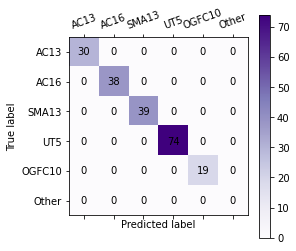

In [15]:
############Test性能测试###################
def identification(predicted_gradient,real_gradient,threshold):
    AC13=[0,6,4,3.5,5.5,7.5,10.5,16,23.5,18.5,5,0]#级配
    AC16=[0,5.4,2.4,2.4,3.7,4.1,7.8,5.5,26.3,20.1,16.6,5.7]#级配 
    SMA13=[0,10.7,2.1,1.4,1.1,1.2,2.9,9.4,30.3,31.5,8.2,1.2]#级配
    UT5=[0,6.7,2,2.5,5,20,13.4,48.8,1.5,0.1,0,0]#级配
    OGFC10=[0,4,1.5,2,2,2.5,4,44,35,5,0,0]#级配
    if np.average(np.abs(real_gradient-AC13))==0:
        Real_result=0
    elif np.average(np.abs(real_gradient-AC16))==0:
        Real_result=1
    elif np.average(np.abs(real_gradient-SMA13))==0:
        Real_result=2
    elif np.average(np.abs(real_gradient-UT5))==0:
        Real_result=3
    elif np.average(np.abs(real_gradient-OGFC10))==0:
        Real_result=4
        
    R_AC13=np.average(np.abs(predicted_gradient-AC13))
    R_AC16=np.average(np.abs(predicted_gradient-AC16))
    R_SMA13=np.average(np.abs(predicted_gradient-SMA13))
    R_UT5=np.average(np.abs(predicted_gradient-UT5))
    R_OGFC10=np.average(np.abs(predicted_gradient-OGFC10))
    
    Predicted_result =np.argmin(np.array([R_AC13,R_AC16,R_SMA13,R_UT5,R_OGFC10]))
    
    if np.min(np.array([R_AC13,R_AC16,R_SMA13,R_UT5,R_OGFC10]))>threshold:
        Predicted_result = 5
    
    return Real_result, Predicted_result

n_classes = 12
Batch_size=8
Vox_ResNet34 = ResNet34(num_classes=12)
Vox_ResNet34.build(input_shape=[(None,103, 103, 21, 1),(None,12)])
Vox_ResNet34.load_weights("Vox_ResNet34-辅助信息.tf")
Vox_ResNet34.compile(optimizer=keras.optimizers.Adam(lr), loss=tf.keras.losses.MAE)
Vox_ResNet34.evaluate([Test_X1_Data,Test_X2_Data],Test_Y_Data)
Thr_list = [0.5,1,1.5,2,2.5,3]
for Thr in Thr_list:
    Real_result = []
    Predicted_result = []
    for i in range(len(Test_X1_Data)):
        R,P=identification(Vox_ResNet34([np.array(Test_X1_Data[i])[np.newaxis,...],np.array(Test_X2_Data[i])[np.newaxis,...]])[0],Test_Y_Data[i],Thr)
        Real_result.append(R)
        Predicted_result.append(P)
    #######绘制混淆矩阵################
    C = confusion_matrix(Real_result, Predicted_result, labels=[0,1,2,3,4,5]) 
    plt.matshow(C, cmap=plt.cm.Purples) # 根据最下面的图按自己需求更改颜色
    plt.colorbar()
    for i in range(len(C)):
        for j in range(len(C)):
            plt.annotate(C[j, i], xy=(i, j), horizontalalignment='center', verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(range(0,6), labels=['AC13','AC16','SMA13','UT5','OGFC10','Other'], rotation=20) # 将x轴或y轴坐标，刻度 替换为文字/字符
    plt.yticks(range(0,6), labels=['AC13','AC16','SMA13','UT5','OGFC10','Other'])
    plt.savefig('C:/Users/Administrator/Desktop/surface/实验结果存放/Vox-ResNet34_辅助信息'+str(Thr)+'.png',dpi=600)#保存图片
    plt.show()